In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from igraph import Graph  # pip install python-igraph
from tqdm import tqdm
from itertools import product
import itertools 
import pandas as pd

In [2]:
data = pd.read_csv("facebook_combined.txt",sep=' ',names=["source", "target"])

In [3]:
data.head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [4]:
data["source"]

0           0
1           0
2           0
3           0
4           0
         ... 
88229    4026
88230    4027
88231    4027
88232    4027
88233    4031
Name: source, Length: 88234, dtype: int64

4,039 nodes

In [5]:
graph = Graph(directed=True)

In [6]:
graph.add_vertices(4039 )
graph.add_edges(zip(data["source"],  data["target"]))

In [7]:
print('vertices count:',  graph.vcount())
print('edges count:',  graph.ecount())
print('neighbors: ', graph.neighbors(2, mode='out'))


vertices count: 4039
edges count: 88234
neighbors:  [20, 115, 116, 149, 226, 312, 326, 333, 343]


In [8]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=1000):
    total_spread = 0

    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = graph.neighbors(node, mode='out')
                success = np.random.uniform(0, 1, len(neighbors)) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list
            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spread += len(active)

    return total_spread / n_iters

In [9]:
def brute_force(graph, k=2, prob=0.2, n_iters=1000):
    #elapsed = []
    #spreads = []
    #solution = []
    start_time = time.time()
    seed_sets=list(itertools.combinations(range(graph.vcount()), k)) 
    #seed_sets=list(product(list(range(graph.vcount())),repeat=k))
    best_spread = -np.inf
    best_seed=[]
    for seed in tqdm(seed_sets):
        spread = compute_independent_cascade(graph,list(seed), prob, n_iters)
        if spread > best_spread:
                best_spread = spread
                best_seed=seed
        #solution.append(best_seed)
       # spreads.append(best_spread)


        #elapse = round(time.time() - start_time, 3)
       # elapsed.append(elapse)
    end_time=time.time()
    return best_seed, best_spread*100/graph.vcount(),round(end_time-start_time,2)

In [10]:
def greedy(graph, k, prob=0.2, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information
    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()
    for _ in tqdm(range(k)):
        best_node = -1
        best_spread = -np.inf

        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        nodes = set(range(graph.vcount())) - set(solution)
        for node in nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node

        solution.append(best_node)
        #spreads.append(best_spread)

        #elapse = round(time.time() - start_time, 3)
       # elapsed.append(elapse)
    end_time=time.time()
    return solution, round(best_spread*100/graph.vcount(),2), round(end_time-start_time, 2)

In [11]:
import heapq


def celf(graph, k, prob, n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Cost Effective Lazy Forward Algorithm, a.k.a Lazy Greedy Algorithm.
    """
    start_time = time.time()

    # find the first node with greedy algorithm:
    # python's heap is a min-heap, thus
    # we negate the spread to get the node
    # with the maximum spread when popping from the heap
    gains = []
    for node in range(graph.vcount()):
        spread = compute_independent_cascade(graph, [node], prob, n_iters)
        heapq.heappush(gains, (-spread, node))

    # we pop the heap to get the node with the best spread,
    # when storing the spread to negate it again to store the actual spread
    spread, node = heapq.heappop(gains)
    solution = [node]
    spread = -spread
    spreads = [spread]

    # record the number of times the spread is computed
    lookups = [graph.vcount()]
    elapsed = [round(time.time() - start_time, 3)]

    for _ in tqdm(range(k - 1)):
        node_lookup = 0
        matched = False

        while not matched:
            node_lookup += 1

            # here we need to compute the marginal gain of adding the current node
            # to the solution, instead of just the gain, i.e. we need to subtract
            # the spread without adding the current node
            _, current_node = heapq.heappop(gains)
            spread_gain = compute_independent_cascade(graph, solution + [current_node], prob, n_iters) - spread

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(gains, (-spread_gain, current_node))
            matched = gains[0][1] == current_node

        # spread stores the cumulative spread
        spread_gain, node = heapq.heappop(gains)
        spread -= spread_gain
        solution.append(node)
        #spreads.append(spread)
        lookups.append(node_lookup)

        #elapse = round(time.time() - start_time, 3)
        #elapsed.append(elapse)
    end_time=time.time()
    return solution, round(spread*100/graph.vcount(),2), round(end_time-start_time, 2), lookups

In [12]:
brute_force_spreads=[] 
brute_force_elapsed=[] 
greedy_spreads=[] 
greedy_elapsed=[] 
celf_spreads=[] 
celf_elapsed=[] 
for i in (range(1,5,1)):
    k = i
    prob = 0.1
    n_iters = 5
    #brute_force_solution1,brute_force_spreads1,brute_force_elapsed1=brute_force(graph,k,prob,n_iters)
    greedy_solution1, greedy_spreads1, greedy_elapsed1 = greedy(graph, k, prob, n_iters)
    celf_solution1, celf_spreads1, celf_elapsed1, celf_lookups1 = celf(graph, k, prob, n_iters)
    
    #brute_force_spreads.append(brute_force_spreads1) 
    #brute_force_elapsed.append(brute_force_elapsed1) 
    greedy_spreads.append(greedy_spreads1)
    greedy_elapsed.append(greedy_elapsed1)
    celf_spreads.append(celf_spreads1) 
    celf_elapsed.append(celf_elapsed1)
   

100%|██████████| 1/1 [00:55<00:00, 55.96s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [10:30<00:00, 210.27s/it]


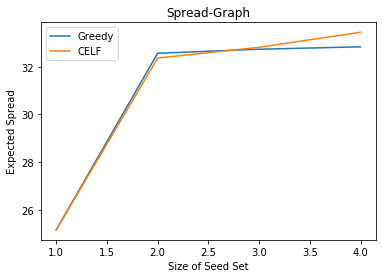

In [13]:
x=list(range(1,5,1))
# plotting the points  
#plt.plot(x, brute_force_spreads,label="Brute-force") 
plt.plot(x, greedy_spreads,label="Greedy")
plt.plot(x, celf_spreads,label="CELF")
# naming the x axis 
plt.xlabel('Size of Seed Set') 
# naming the y axis 
plt.ylabel('Expected Spread') 
  
# giving a title to my graph 
plt.title('Spread-Graph') 
plt.legend()
# function to show the plot 
plt.show() 

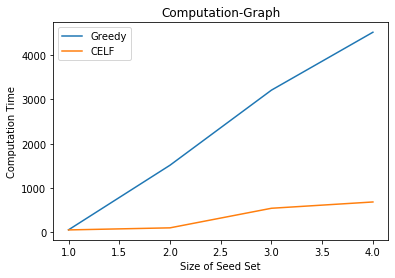

In [14]:
# plotting the points  
#plt.plot(x, brute_force_elapsed,label="Brute-force") 
plt.plot(x, greedy_elapsed,label="Greedy")
plt.plot(x, celf_elapsed,label="CELF")
# naming the x axis 
plt.xlabel('Size of Seed Set') 
# naming the y axis 
plt.ylabel('Computation Time') 
  
# giving a title to my graph 
plt.title('Computation-Graph') 
plt.legend()
# function to show the plot 
plt.show() 